In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression

Amino_acid_dict = {'Ala': 'A',
                   'Cys': 'C',
                   'Asp': 'D',
                   'Glu': 'E',
                   'Phe': 'F',
                   'Gly': 'G',
                   'His': 'H',
                   'Ile': 'I',
                   'Lys': 'K',
                   'Leu': 'L',
                   'Met': 'M',
                   'Asn': 'N',                   
                   'Pro': 'P',
                   'Gln': 'Q',
                   'Arg': 'R',
                   'Ser': 'S',
                   'Thr': 'T',
                   'Val': 'V',
                   'Trp': 'W',
                   'Tyr': 'Y',
                   'Ter': '*',
                   'wt':'wt'
                  }

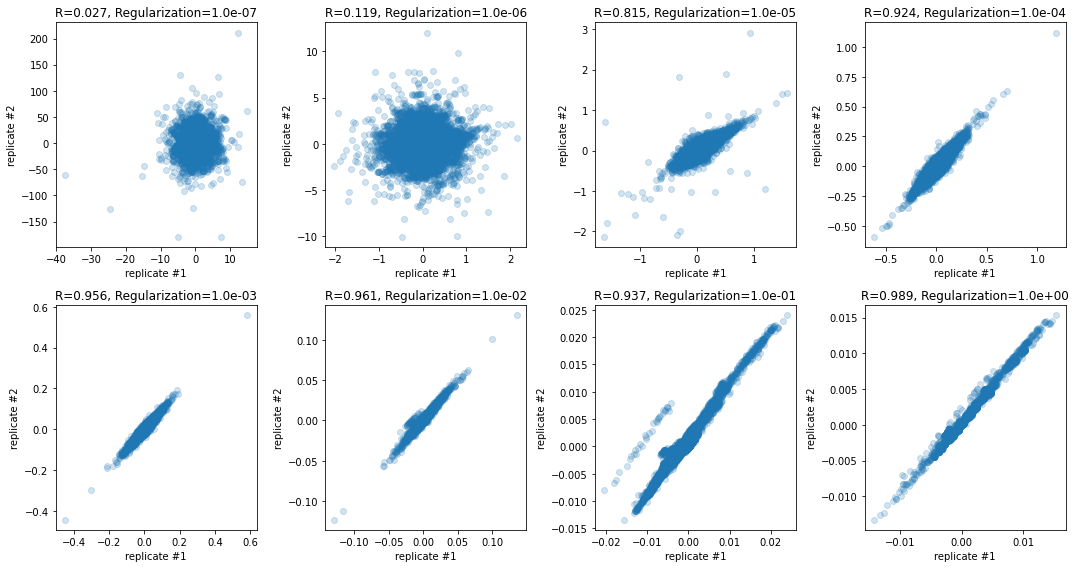

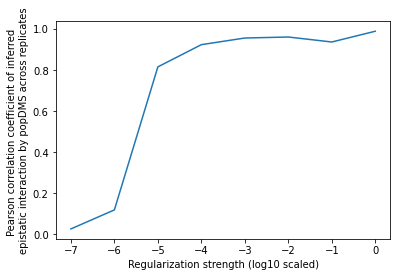

In [5]:
regularization = [-7,-6,-5,-4,-3,-2,-1,0]
epistasis_dir = "./output/epistasis/raw_epistasis/"
epistasis_output_file = "./output/epistasis/"
target_protein = "YAP1"
index_file = epistasis_output_file+"index_matrix.csv"
epistasis_prefix = epistasis_dir+target_protein
replicates = 2
SEQUENCE   = "DVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPR"
regular_optimized = -3

epistasis_rep1 = []
epistasis_rep2 = []
epistasis_joint = []

for regular in regularization:
    with open(epistasis_prefix+"_epistasis_rep1_"+str(regular)+".txt") as file_in:
        lines = []
        for line in file_in:
            lines.append(float(line))
        epistasis_rep1.append(lines)

    with open(epistasis_prefix+"_epistasis_rep2_"+str(regular)+".txt") as file_in:
        lines = []
        for line in file_in:
            lines.append(float(line))
        epistasis_rep2.append(lines)     

fig = plt.figure(figsize = (15,8))
pearsonr = []
for idx in range(len(regularization)):
    
    plt.subplot(2, 4, idx+1)
    plt.scatter(epistasis_rep1[idx], epistasis_rep2[idx], alpha=0.2)
    plt.xlabel("replicate #1")
    plt.ylabel("replicate #2")
    plt.title("R=%.3f, Regularization=%.1e" %(round(st.pearsonr(epistasis_rep1[idx], epistasis_rep2[idx])[0], 3), 10**regularization[idx]))
    pearsonr.append(st.pearsonr(epistasis_rep1[idx], epistasis_rep2[idx])[0])
fig.tight_layout()
plt.show()

plt.plot(regularization, pearsonr)
plt.xlabel("Regularization strength (log10 scaled)")
plt.ylabel("Pearson correlation coefficient of inferred \nepistatic interaction by popDMS across replicates")
plt.show()

AA_idx_dict = {"*":0, "A":1, "C":2, "D":3, "E":4, "F":5, "G":6, "H":7, "I":8, "K":9, "L":10, "M":11, "N":12,
               "P": 13, "Q":14, "R":15, "S":16, "T":17, "V":18, "W":19, "Y":20}
idx_AA_dict = dict((v,k) for k,v in AA_idx_dict.items())

df_index = pd.read_csv(index_file, header = None)
df_index = df_index.rename(columns={0:"variant_idx1", 1:"variant_idx2", 2:"idx"})
df_index["site1"] = (df_index["variant_idx1"]/21).astype('int')+1
df_index["variant1"] = df_index["variant_idx1"]%21
df_index["variant1"] = df_index["variant1"].map(idx_AA_dict)
df_index["site2"] = (df_index["variant_idx2"]/21).astype('int')+1
df_index["variant2"] = df_index["variant_idx2"]%21
df_index["variant2"] = df_index["variant2"].map(idx_AA_dict)
df_index.sort_values("idx")

with open(epistasis_prefix+"_epistasis_rep1_"+str(regular_optimized)+".txt") as file_in:
    lines1 = []
    for line in file_in:
        lines1.append(float(line))

with open(epistasis_prefix+"_epistasis_rep2_"+str(regular_optimized)+".txt") as file_in:
    lines2 = []
    for line in file_in:
        lines2.append(float(line))

with open(epistasis_prefix+"_epistasis_joint_"+str(regular_optimized)+".txt") as file_in:
    lines_joint = []
    for line in file_in:
        lines_joint.append(float(line))

idx = [i for i in range(df_index.shape[0])]
df_inference = pd.DataFrame(columns = ["idx", "rep_1", "rep_2", "joint"])
df_inference["idx"] = idx
df_inference["rep_1"] = lines1
df_inference["rep_2"] = lines2
df_inference["joint"] = lines_joint
df_inference

df_merged_popDMS = pd.merge(df_index, df_inference, on="idx")
df_merged_popDMS = df_merged_popDMS.drop(["variant_idx1", "variant_idx2", "idx"], axis=1)

for i in range(df_merged_popDMS.shape[0]):
    site = df_merged_popDMS.at[i, "site1"]
    if df_merged_popDMS.at[i, "variant1"] == SEQUENCE[site-1]:

        df_merged_popDMS.at[i, "WT_indicator_1"] = True
    else:
        df_merged_popDMS.at[i, "WT_indicator_1"] = False
    site = df_merged_popDMS.at[i, "site2"]
    if df_merged_popDMS.at[i, "variant2"] == SEQUENCE[site-1]:
        df_merged_popDMS.at[i, "WT_indicator_2"] = True
    else:
        df_merged_popDMS.at[i, "WT_indicator_2"] = False
df_merged_popDMS = df_merged_popDMS[["site1", "variant1", "WT_indicator_1", 
                                     "site2", "variant2", "WT_indicator_2",
                                     "rep_1", "rep_2", "joint"]]
df_merged_popDMS = df_merged_popDMS.rename(columns={"variant1": "amino_acid_1", "variant2": "amino_acid_2", 
                                                    "site1": "site_1", "site2": "site_2"})

df_merged_popDMS.to_csv(epistasis_output_file+target_protein+"_popDMS_"+str(int(regular_optimized))+".csv.gz", compression = "gzip", index=False)


In [8]:
shift = -1
WT = SEQUENCE
df_merged_popDMS = pd.read_csv(epistasis_output_file+target_protein+"_popDMS_"+str(int(regular_optimized))+".csv.gz", compression = "gzip")
df_merged_popDMS = df_merged_popDMS.rename(columns={"rep_1": "popDMS_rep_1", 
                                                    "rep_2": "popDMS_rep_2", 
                                                    "joint": "popDMS_joint"})

df_merged_popDMS['popDMS_consensus_rep_1'] = np.zeros(len(df_merged_popDMS)) 
sijab_list_1 = []
sijab_list_2 = []
sijab_list_joint = []
iii=0
for _, row in df_merged_popDMS.iterrows():
    i = row['site_1']
    j = row['site_2']
    
    sijcb_rec = df_merged_popDMS[(df_merged_popDMS['site_1']==i) & (df_merged_popDMS['site_2']==j) & 
                                 (df_merged_popDMS['amino_acid_1']==WT[i+shift]) & 
                                 (df_merged_popDMS['amino_acid_2']==row['amino_acid_2'])]
    
    sijac_rec = df_merged_popDMS[(df_merged_popDMS['site_1']==i) & (df_merged_popDMS['site_2']==j) &
                                 (df_merged_popDMS['amino_acid_1']==row['amino_acid_1']) & 
                                 (df_merged_popDMS['amino_acid_2']==WT[j+shift])]
    
    sijcc_rec = df_merged_popDMS[(df_merged_popDMS['site_1']==i) & (df_merged_popDMS['site_2']==j) &
                                 (df_merged_popDMS['amino_acid_1']==WT[i+shift]) & 
                                 (df_merged_popDMS['amino_acid_2']==WT[j+shift])]
      
    if len(sijcb_rec)==0:
        sijcb=0
    else:
        sijcb=sijcb_rec.iloc[0]['popDMS_rep_1']
    if len(sijac_rec)==0:
        sijac=0
    else:
        sijac=sijac_rec.iloc[0]['popDMS_rep_1']
    if len(sijcc_rec)==0:
        sijcc=0
    else:
        sijcc=sijcc_rec.iloc[0]['popDMS_rep_1']
    sijab = row['popDMS_rep_1'] - sijcb - sijac + sijcc
    sijab_list_1.append(sijab)
    
    
    if len(sijcb_rec)==0:
        sijcb=0
    else:
        sijcb=sijcb_rec.iloc[0]['popDMS_rep_2']
    if len(sijac_rec)==0:
        sijac=0
    else:
        sijac=sijac_rec.iloc[0]['popDMS_rep_2']
    if len(sijcc_rec)==0:
        sijcc=0
    else:
        sijcc=sijcc_rec.iloc[0]['popDMS_rep_2']
    sijab = row['popDMS_rep_2'] - sijcb
    sijab -= sijac
    sijab += sijcc
    sijab_list_2.append(sijab)
    
    
    if len(sijcb_rec)==0:
        sijcb=0
    else:
        sijcb=sijcb_rec.iloc[0]['popDMS_joint']
    if len(sijac_rec)==0:
        sijac=0
    else:
        sijac=sijac_rec.iloc[0]['popDMS_joint']
    if len(sijcc_rec)==0:
        sijcc=0
    else:
        sijcc=sijcc_rec.iloc[0]['popDMS_joint']
    sijab = row['popDMS_joint'] - sijcb
    sijab -= sijac
    sijab += sijcc
    sijab_list_joint.append(sijab)

df_merged_popDMS['popDMS_consensus_rep_1'] = sijab_list_1
df_merged_popDMS['popDMS_consensus_rep_2'] = sijab_list_2
df_merged_popDMS['popDMS_consensus_joint'] = sijab_list_joint
# df_merged_popDMS.to_csv("./merged_popDMS_consensus_"+str(int(regular_optimized))+".csv.gz")
df_merged_popDMS

,site_1,amino_acid_1,WT_indicator_1,site_2,amino_acid_2,WT_indicator_2,popDMS_rep_1,popDMS_rep_2,popDMS_joint,popDMS_consensus_rep_1,popDMS_consensus_rep_2,popDMS_consensus_joint
0,34,Y,False,34,Y,False,-0.002521,-0.001635,-0.002041,-0.128820,-0.104095,-1.925628e-01
1,34,W,False,34,W,False,-0.003921,-0.002766,-0.004701,-0.130220,-0.105226,-1.952232e-01
2,34,V,False,34,V,False,-0.001726,-0.003569,-0.002926,-0.128025,-0.106029,-1.934484e-01
3,34,T,False,34,T,False,0.001390,-0.000653,0.000519,-0.124909,-0.103113,-1.900027e-01
4,34,S,False,34,S,False,0.021297,0.018736,0.036675,-0.105002,-0.083724,-1.538466e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
39513,1,*,False,4,L,True,-0.016537,-0.019440,-0.020435,0.000000,0.000000,0.000000e+00
39514,1,*,False,7,G,True,-0.016537,-0.019440,-0.020435,0.000000,0.000000,1.387779e-17
39515,1,*,False,12,I,False,0.000354,0.000259,0.000984,0.051843,0.067322,5.719007e-02
39516,1,*,False,3,P,True,-0.016537,-0.019440,-0.020435,0.000000,0.000000,0.000000e+00


In [9]:

df_merged_popDMS_single = df_merged_popDMS[(df_merged_popDMS["site_1"]==df_merged_popDMS["site_2"])&
                                           (df_merged_popDMS["amino_acid_1"]==df_merged_popDMS["amino_acid_2"])]

with_s12_list=[]
without_s12_list=[]

with_s12_list1=[]
without_s12_list1=[]

with_s12_list2=[]
without_s12_list2=[]

epistasis_transfer_popDMS_1 = []
epistasis_transfer_popDMS_2 = []
epistasis_transfer_popDMS_joint = []

s1_rep1 = []
s2_rep1 = []
s12_rep1 = []

s1_rep2 = []
s2_rep2 = []
s12_rep2 = []

s1_joint = []
s2_joint = []
s12_joint = []


for idx,row in df_merged_popDMS.iterrows():
    site1=row["site_1"]
    site2=row["site_2"]
    AA1=row["amino_acid_1"]
    AA2=row["amino_acid_2"]
    s12=row["popDMS_consensus_joint"]
    s1=df_merged_popDMS_single[(df_merged_popDMS_single["site_1"]==site1)&
                               (df_merged_popDMS_single["amino_acid_1"]==AA1)]["popDMS_consensus_joint"].values[0]
    s2=df_merged_popDMS_single[(df_merged_popDMS_single["site_1"]==site2)&
                               (df_merged_popDMS_single["amino_acid_1"]==AA2)]["popDMS_consensus_joint"].values[0]
    with_s12_list.append(s1+s2+s12)
    without_s12_list.append(s1+s2)
    epistasis_transfer_popDMS_joint.append(s12-s1*s2)
    s1_joint.append(s1)
    s2_joint.append(s2)
    s12_joint.append(s12)
    
    s12=row["popDMS_consensus_rep_1"]
    s1=df_merged_popDMS_single[(df_merged_popDMS_single["site_1"]==site1)&
                               (df_merged_popDMS_single["amino_acid_1"]==AA1)]["popDMS_consensus_rep_1"].values[0]
    s2=df_merged_popDMS_single[(df_merged_popDMS_single["site_1"]==site2)&
                               (df_merged_popDMS_single["amino_acid_1"]==AA2)]["popDMS_consensus_rep_1"].values[0]
    with_s12_list1.append(s1+s2+s12)
    without_s12_list1.append(s1+s2)
    epistasis_transfer_popDMS_1.append(s12-s1*s2)
    s1_rep1.append(s1)
    s2_rep1.append(s2)
    s12_rep1.append(s12)
    
    s12=row["popDMS_consensus_rep_2"]
    s1=df_merged_popDMS_single[(df_merged_popDMS_single["site_1"]==site1)&
                               (df_merged_popDMS_single["amino_acid_1"]==AA1)]["popDMS_consensus_rep_2"].values[0]
    s2=df_merged_popDMS_single[(df_merged_popDMS_single["site_1"]==site2)&
                               (df_merged_popDMS_single["amino_acid_1"]==AA2)]["popDMS_consensus_rep_2"].values[0]
    with_s12_list2.append(s1+s2+s12)
    without_s12_list2.append(s1+s2)
    epistasis_transfer_popDMS_2.append(s12-s1*s2)
    s1_rep2.append(s1)
    s2_rep2.append(s2)
    s12_rep2.append(s12)

df_merged_popDMS["s1+s2_joint"] = without_s12_list
df_merged_popDMS["s1+s2+s12_joint"] = with_s12_list
df_merged_popDMS["s1+s2_rep_1"] = without_s12_list1
df_merged_popDMS["s1+s2+s12_rep_1"] = with_s12_list1
df_merged_popDMS["s1+s2_rep_2"] = without_s12_list2
df_merged_popDMS["s1+s2+s12_rep_2"] = with_s12_list2
df_merged_popDMS["epistasis_transfer_popDMS_1"] = epistasis_transfer_popDMS_1
df_merged_popDMS["epistasis_transfer_popDMS_2"] = epistasis_transfer_popDMS_2
df_merged_popDMS["epistasis_transfer_popDMS_joint"] = epistasis_transfer_popDMS_joint
df_merged_popDMS["s1_rep_1"] = s1_rep1
df_merged_popDMS["s2_rep_1"] = s2_rep1
df_merged_popDMS["s12_rep_1"] = s12_rep1
df_merged_popDMS["s1_rep_2"] = s1_rep2
df_merged_popDMS["s2_rep_2"] = s2_rep2
df_merged_popDMS["s12_rep_2"] = s12_rep2
df_merged_popDMS["s1_joint"] = s1_joint
df_merged_popDMS["s2_joint"] = s2_joint
df_merged_popDMS["s12_joint"] = s12_joint

df_merged_popDMS

,site_1,amino_acid_1,WT_indicator_1,site_2,amino_acid_2,WT_indicator_2,popDMS_rep_1,popDMS_rep_2,popDMS_joint,popDMS_consensus_rep_1,...,epistasis_transfer_popDMS_joint,s1_rep_1,s2_rep_1,s12_rep_1,s1_rep_2,s2_rep_2,s12_rep_2,s1_joint,s2_joint,s12_joint
0,34,Y,False,34,Y,False,-0.002521,-0.001635,-0.002041,-0.128820,...,-2.296432e-01,-0.128820,-0.128820,-0.128820,-0.104095,-0.104095,-0.104095,-0.192563,-0.192563,-1.925628e-01
1,34,W,False,34,W,False,-0.003921,-0.002766,-0.004701,-0.130220,...,-2.333353e-01,-0.130220,-0.130220,-0.130220,-0.105226,-0.105226,-0.105226,-0.195223,-0.195223,-1.952232e-01
2,34,V,False,34,V,False,-0.001726,-0.003569,-0.002926,-0.128025,...,-2.308707e-01,-0.128025,-0.128025,-0.128025,-0.106029,-0.106029,-0.106029,-0.193448,-0.193448,-1.934484e-01
3,34,T,False,34,T,False,0.001390,-0.000653,0.000519,-0.124909,...,-2.261037e-01,-0.124909,-0.124909,-0.124909,-0.103113,-0.103113,-0.103113,-0.190003,-0.190003,-1.900027e-01
4,34,S,False,34,S,False,0.021297,0.018736,0.036675,-0.105002,...,-1.775154e-01,-0.105002,-0.105002,-0.105002,-0.083724,-0.083724,-0.083724,-0.153847,-0.153847,-1.538466e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39513,1,*,False,4,L,True,-0.016537,-0.019440,-0.020435,0.000000,...,0.000000e+00,0.146975,0.000000,0.000000,0.153014,0.000000,0.000000,0.258390,0.000000,0.000000e+00
39514,1,*,False,7,G,True,-0.016537,-0.019440,-0.020435,0.000000,...,1.387779e-17,0.146975,0.000000,0.000000,0.153014,0.000000,0.000000,0.258390,0.000000,1.387779e-17
39515,1,*,False,12,I,False,0.000354,0.000259,0.000984,0.051843,...,6.072377e-02,0.146975,-0.018182,0.051843,0.153014,-0.010433,0.067322,0.258390,-0.013676,5.719007e-02
39516,1,*,False,3,P,True,-0.016537,-0.019440,-0.020435,0.000000,...,0.000000e+00,0.146975,0.000000,0.000000,0.153014,0.000000,0.000000,0.258390,0.000000,0.000000e+00


In [11]:
def preference_transform(count_file, column_prefix, rep):
    
    df_count = pd.read_csv(count_file, compression="gzip")
    site_list = []
    score_list = []
    double_mutant = {}
    single_mutant = {}
    for i,j,k,l,m in zip(df_count['hgvs_pro'].tolist(), df_count[column_prefix+str(0)].tolist(), df_count[column_prefix+str(1)].tolist(), df_count[column_prefix+str(2)].tolist(), df_count[column_prefix+str(3)].tolist()):
        r = re.compile("([a-zA-Z]+)([0-9]+)")
        string_list = re.split(r'(\w+)', i)
        string_list = [i for i in string_list if len(i)>6]
        if len(string_list)==1:
            single_mutant[string_list[0]] = [j,k,l,m]
        if len(string_list)==2:
            double_mutant[str(string_list)] = [j,k,l,m]
    wt_row = df_count.loc[df_count['hgvs_pro'].str.contains('wt')]
    total_single_count = []
    total_double_count = []
    total_ter_count = []
    for i in range(4):
        total_single_count.append(sum([float(v[i]) for v in single_mutant.values()])+wt_row[column_prefix+str(i)].values[0])
        total_double_count.append(sum([float(v[i]) for v in double_mutant.values()])+wt_row[column_prefix+str(i)].values[0])
        total_ter_count.append(sum([float(v[i]) for v,x in zip(single_mutant.values(), single_mutant.keys()) if x[-3:]=='Ter']))

    total_single_count

    carryover_rate = [i/j for i,j in zip(total_ter_count, total_single_count)]

    single_count_table = pd.DataFrame.from_dict(single_mutant,orient='index').reset_index()
    double_count_table = pd.DataFrame.from_dict(double_mutant,orient='index').reset_index()

    double_count_table['mutant1'] = [i.strip('][').split(', ')[0][1:-1] for i in double_count_table['index']]
    double_count_table['mutant2'] = [i.strip('][').split(', ')[1][1:-1] for i in double_count_table['index']]
    double_count_table = double_count_table.drop('index', axis=1)

    double_count_table

    for i in range(4):
        double_count_table[[i]]/=total_single_count[i]
        single_count_table[[i]]/=total_double_count[i]
    df2 = {'index':'wt', 
           0: wt_row[column_prefix+str(0)].values[0]/total_single_count[0],
           1: wt_row[column_prefix+str(1)].values[0]/total_single_count[1],
           2: wt_row[column_prefix+str(2)].values[0]/total_single_count[2],
           3: wt_row[column_prefix+str(3)].values[0]/total_single_count[3]}
    single_count_table = single_count_table.append(df2, ignore_index = True)
    df2 = {'mutant1':'wt', 
           'mutant2':'wt', 
           0: wt_row[column_prefix+str(0)].values[0]/total_single_count[0],
           1: wt_row[column_prefix+str(1)].values[0]/total_single_count[1],
           2: wt_row[column_prefix+str(2)].values[0]/total_single_count[2],
           3: wt_row[column_prefix+str(3)].values[0]/total_single_count[3]}
    double_count_table = double_count_table.append(df2, ignore_index = True)
    for i in range(1,4):

        NSCOR_input = [k*(1-carryover_rate[i]) for k in single_count_table[i-1]]
        NSCOR_output = [j - k*carryover_rate[i] for k,j in zip(single_count_table[i-1], single_count_table[i])]
        single_count_table['NSCOR_ratio_'+str(i)] = [j/k for k,j in zip(NSCOR_input, NSCOR_output)]
        NSCOR_input = [k*(1-carryover_rate[i]) for k in double_count_table[i-1]]
        NSCOR_output = [j - k*carryover_rate[i] for k,j in zip(double_count_table[i-1], double_count_table[i])]
        double_count_table['NSCOR_ratio_'+str(i)] = [j/k for k,j in zip(NSCOR_input, NSCOR_output)]


    single_count_table['projected_0'] = 0

    single_count_table['projected_1'] = [np.log2(i) for i in single_count_table['NSCOR_ratio_1'].tolist()]
    single_count_table['projected_2'] = [np.log2(i*j) for i,j in zip(single_count_table['NSCOR_ratio_1'].tolist(),
                                                                     single_count_table['NSCOR_ratio_2'].tolist())]
    single_count_table['projected_3'] = [np.log2(i*j*k) for i,j,k in zip(single_count_table['NSCOR_ratio_1'].tolist(),
                                                                         single_count_table['NSCOR_ratio_2'].tolist(),
                                                                         single_count_table['NSCOR_ratio_3'].tolist())]
    double_count_table['projected_0'] = 0

    double_count_table['projected_1'] = [np.log2(i) for i in double_count_table['NSCOR_ratio_1'].tolist()]
    double_count_table['projected_2'] = [np.log2(i*j) for i,j in zip(double_count_table['NSCOR_ratio_1'].tolist(),
                                                                     double_count_table['NSCOR_ratio_2'].tolist())]
    double_count_table['projected_3'] = [np.log2(i*j*k) for i,j,k in zip(double_count_table['NSCOR_ratio_1'].tolist(),
                                                                         double_count_table['NSCOR_ratio_2'].tolist(),
                                                                         double_count_table['NSCOR_ratio_3'].tolist())]

    slope = []
    for i in range(single_count_table.shape[0]):
        X = np.array([1,2,3,4]).reshape(4,1)
        row = single_count_table.iloc[i,:]
        y =  np.array([row['projected_0'], row['projected_1'], row['projected_2'], row['projected_3']]).reshape(4,1)
        reg = LinearRegression().fit(X, y)

        if reg.score(X,y)>0.75:
            slope.append(reg.coef_[0][0])
        else:
            slope.append(np.nan)
    single_count_table['slope_v'] = slope

    slope = []
    for i in range(double_count_table.shape[0]):
        X = np.array([1,2,3,4]).reshape(4,1)
        row = double_count_table.iloc[i,:]
        y =  np.array([row['projected_0'], row['projected_1'], row['projected_2'], row['projected_3']]).reshape(4,1)
        reg = LinearRegression().fit(X, y)
        if reg.score(X,y)>0:
            slope.append(reg.coef_[0][0])
        else:
            slope.append(np.nan)

    double_count_table['slope_v'] = slope

    double_count_table = double_count_table.dropna()
    single_count_table = single_count_table.dropna()

    wt_score = single_count_table.loc[single_count_table['index']=='wt']['slope_v'].values[0]
    single_count_table['function_score'] = [2**(i-wt_score) for i in single_count_table['slope_v'].tolist()]
    single_count_table

    double_count_table['function_score'] = [2**(i-wt_score) for i in double_count_table['slope_v'].tolist()]
    double_count_table

    predicted_score = []
    single_score_1 = []
    single_score_2 = []
    single_mut_list = single_count_table['index'].tolist()
    for i in range(double_count_table.shape[0]-1):
        mut1 = double_count_table.iloc[i]['mutant1']
        mut2 = double_count_table.iloc[i]['mutant2']
        if mut1 in single_mut_list and mut2 in single_mut_list:
            single_score1 = single_count_table.loc[single_count_table['index']==mut1]['function_score'].values[0]
            single_score2 = single_count_table.loc[single_count_table['index']==mut2]['function_score'].values[0]
            predicted_score.append(single_score1*single_score2)
            single_score_1.append(single_score1)
            single_score_2.append(single_score2)
        else:
            predicted_score.append(np.nan)
            single_score_1.append(np.nan)
            single_score_2.append(np.nan)            
    predicted_score.append(1)
    single_score_1.append(1)
    single_score_2.append(1)
    double_count_table['predicted_score'] = predicted_score
    double_count_table['functional_score_1'] = single_score_1
    double_count_table['functional_score_2'] = single_score_2
    double_count_table = double_count_table.dropna()
    double_count_table_ = double_count_table.iloc[:-1].copy()
    double_count_table_['site_1'] = [int(i[3:-3]) for i in double_count_table_['mutant1'].tolist() ]
    double_count_table_['site_2'] = [int(i[3:-3]) for i in double_count_table_['mutant2'].tolist() ]
    double_count_table_['AA_1'] = [Amino_acid_dict[i[-3:]] for i in double_count_table_['mutant1'].tolist()]
    double_count_table_['AA_2'] = [Amino_acid_dict[i[-3:]] for i in double_count_table_['mutant2'].tolist()]
    double_count_table_['all_variant'] = [str(i)+'_'+str(j)+'_'+str(k)+'_'+str(l) for i,j,k,l in zip(double_count_table_['site_1'], double_count_table_['AA_1'],double_count_table_['site_2'],double_count_table_['AA_2'])]
    double_count_table_['epistasis_paper'] = double_count_table_['function_score'] - double_count_table_['predicted_score']
    double_count_table_ = double_count_table_.rename(columns={"AA_1": "amino_acid_1", "AA_2": "amino_acid_2", "epistasis_paper": "rep_"+str(rep)})
    return double_count_table_, single_count_table

column_prefix = '101208_c_'
count_file = "./output/haplotype_counts/YAP1_haplotype_counts.csv.gzip"
preference_1, single_1 = preference_transform(count_file,column_prefix,1)

column_prefix = '110307_c_'
count_file = "./output/haplotype_counts/YAP1_haplotype_counts.csv.gzip"
preference_2, single_2 = preference_transform(count_file,column_prefix,2)

preference_rep1 = preference_1[["site_1", "amino_acid_1", "site_2", "amino_acid_2", 
                                "function_score", "functional_score_1", "functional_score_2"]].copy()
preference_rep2 = preference_2[["site_1", "amino_acid_1", "site_2", "amino_acid_2", 
                                "function_score", "functional_score_1", "functional_score_2"]].copy()
preference_merge = pd.merge(preference_rep1, preference_rep2, on=["site_1", "amino_acid_1", "site_2", "amino_acid_2"])
preference_merge = preference_merge.rename(columns={"function_score_x": "functional_score_rep1",
                                                    "functional_score_1_x": "functional_score_1_rep1",
                                                    "functional_score_2_x": "functional_score_2_rep1",
                                                    "function_score_y": "functional_score_rep2",
                                                    "functional_score_1_y": "functional_score_1_rep2",
                                                    "functional_score_2_y": "functional_score_2_rep2"})

preference_merge

,site_1,amino_acid_1,site_2,amino_acid_2,log2wab-log2wa-log2wb_rep1,log2wab-log2wa-log2wb_rep2
0,22,T,23,L,0.958615,0.928706
1,4,R,15,F,-1.049587,-1.080875
2,6,V,19,S,-0.099683,-0.085675
3,9,G,12,Q,-0.060345,-0.076807
4,2,A,25,N,-0.348513,-0.364913
...,...,...,...,...,...,...
14210,5,L,16,S,-0.385556,-0.443514
14211,17,H,18,H,-0.253341,-0.301655
14212,6,S,8,*,0.040036,-0.007925
14213,8,R,9,G,-0.762438,-0.794136


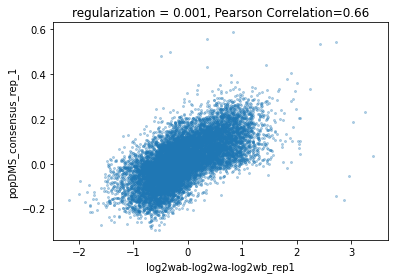

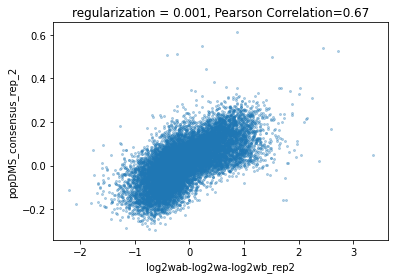

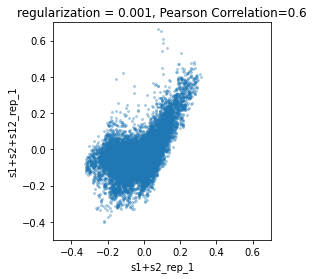

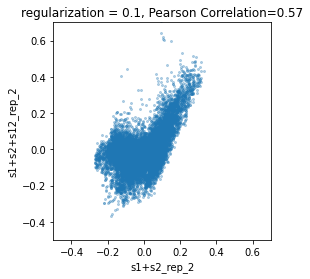

In [13]:
df_merge_functional_score = pd.merge(preference_merge, 
                                     df_merged_popDMS, 
                                     on=["site_1", "site_2", "amino_acid_1", "amino_acid_2"])

df_merge_functional_score["wa*wb_log2_rep1"] = np.log2(df_merge_functional_score["functional_score_1_rep1"]*df_merge_functional_score["functional_score_2_rep1"])
df_merge_functional_score["wa*wb_log2_rep2"] = np.log2(df_merge_functional_score["functional_score_1_rep2"]*df_merge_functional_score["functional_score_2_rep2"])
df_merge_functional_score["functional_score_log2_rep1"] = np.log2(df_merge_functional_score["functional_score_rep1"])
df_merge_functional_score["functional_score_log2_rep2"] = np.log2(df_merge_functional_score["functional_score_rep2"])

df_merge_functional_score["s_a_rep1"] = np.log2(df_merge_functional_score["functional_score_1_rep1"])
df_merge_functional_score["s_a_rep2"] = np.log2(df_merge_functional_score["functional_score_1_rep2"])
df_merge_functional_score["s_b_rep1"] = np.log2(df_merge_functional_score["functional_score_2_rep1"])
df_merge_functional_score["s_b_rep2"] = np.log2(df_merge_functional_score["functional_score_2_rep2"])
df_merge_functional_score["s_ab_rep1"] = np.log2(df_merge_functional_score["functional_score_rep1"])
df_merge_functional_score["s_ab_rep2"] = np.log2(df_merge_functional_score["functional_score_rep2"])
df_merge_functional_score["log2wab-log2wa-log2wb_rep1"] = df_merge_functional_score["s_ab_rep1"] - df_merge_functional_score["s_a_rep1"] - df_merge_functional_score["s_b_rep1"]
df_merge_functional_score["log2wab-log2wa-log2wb_rep2"] = df_merge_functional_score["s_ab_rep2"] - df_merge_functional_score["s_a_rep2"] - df_merge_functional_score["s_b_rep2"]

df_comparison = df_merge_functional_score[["site_1", "amino_acid_1", "site_2", "amino_acid_2", 
                                           "log2wab-log2wa-log2wb_rep1", "log2wab-log2wa-log2wb_rep2",
                                           "popDMS_consensus_rep_1", "popDMS_consensus_rep_2",
                                           's1+s2_rep_1', 's1+s2+s12_rep_1', 's1+s2_rep_2', 's1+s2+s12_rep_2']]


corr=round(st.pearsonr(df_comparison["log2wab-log2wa-log2wb_rep1"], df_comparison["popDMS_consensus_rep_1"])[0],2)
df_comparison.plot.scatter(x="log2wab-log2wa-log2wb_rep1", y="popDMS_consensus_rep_1", alpha=0.3, s=4)
plt.title("regularization = 0.001, Pearson Correlation="+str(corr))
plt.show()
corr=round(st.pearsonr(df_comparison["log2wab-log2wa-log2wb_rep2"], df_comparison["popDMS_consensus_rep_2"])[0],2)
df_comparison.plot.scatter(x="log2wab-log2wa-log2wb_rep2", y="popDMS_consensus_rep_2", alpha=0.3, s=4)
plt.title("regularization = 0.001, Pearson Correlation="+str(corr))
plt.show()

corr=round(st.pearsonr(df_comparison["s1+s2_rep_1"], df_comparison["s1+s2+s12_rep_1"])[0],2)
df_comparison.plot.scatter(x="s1+s2_rep_1", y="s1+s2+s12_rep_1", alpha=0.3, s=4)
plt.title("regularization = 0.001, Pearson Correlation="+str(corr))
plt.axis('square')
plt.xlim([-0.5,0.7])
plt.ylim([-0.5,0.7])
plt.show()


corr=round(st.pearsonr(df_comparison["s1+s2_rep_2"], df_comparison["s1+s2+s12_rep_2"])[0],2)
df_comparison.plot.scatter(x="s1+s2_rep_2", y="s1+s2+s12_rep_2", alpha=0.3, s=4)
plt.title("regularization = 0.1, Pearson Correlation="+str(corr))
plt.axis('square')
plt.xlim([-0.5,0.7])
plt.ylim([-0.5,0.7])
plt.show()

In [16]:
df_merge_functional_score.to_csv("./output/epistasis/merged_epistasis.csv.gz", compression="gzip")

In [17]:
df_merge_functional_score

,site_1,amino_acid_1,site_2,amino_acid_2,functional_score_rep1,functional_score_1_rep1,functional_score_2_rep1,functional_score_rep2,functional_score_1_rep2,functional_score_2_rep2,...,functional_score_log2_rep1,functional_score_log2_rep2,s_a_rep1,s_a_rep2,s_b_rep1,s_b_rep2,s_ab_rep1,s_ab_rep2,log2wab-log2wa-log2wb_rep1,log2wab-log2wa-log2wb_rep2
0,22,T,23,L,0.445744,0.515652,0.444792,0.248338,0.529319,0.442384,...,-1.165713,-2.009623,-0.955531,-0.917791,-1.168797,-1.176629,-1.165713,-2.009623,0.958615,0.084797
1,4,R,15,F,0.303653,0.555585,1.131316,0.294075,0.562172,1.142573,...,-1.719505,-1.765743,-0.847919,-0.830915,0.178002,0.192286,-1.719505,-1.765743,-1.049587,-1.127114
2,6,V,19,S,0.473539,1.065057,0.476421,0.343652,1.051551,0.477877,...,-1.078443,-1.540981,0.090931,0.072519,-1.069691,-1.065288,-1.078443,-1.540981,-0.099683,-0.548212
3,9,G,12,Q,1.617712,1.724761,0.977998,1.557167,1.751851,0.973925,...,0.693955,0.638924,0.786396,0.808880,-0.032096,-0.038118,0.693955,0.638924,-0.060345,-0.131838
4,2,A,25,N,1.482614,1.287004,1.466766,1.620306,1.273084,1.499757,...,0.568143,0.696266,0.364017,0.348327,0.552639,0.584728,0.568143,0.696266,-0.348513,-0.236789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13878,5,L,16,S,0.362331,0.679815,0.696272,0.418184,0.699030,0.704889,...,-1.464619,-1.257791,-0.556786,-0.516573,-0.522277,-0.504532,-1.464619,-1.257791,-0.385556,-0.236686
13879,17,H,18,H,0.940288,1.046912,1.070567,1.041161,1.062057,1.091240,...,-0.088826,0.058194,0.066140,0.086861,0.098375,0.125968,-0.088826,0.058194,-0.253341,-0.154636
13880,6,S,8,*,0.531999,1.067357,0.484786,0.465689,1.076442,0.496942,...,-0.910503,-1.102560,0.094042,0.106271,-1.044581,-1.008849,-0.910503,-1.102560,0.040036,-0.199982
13881,8,R,9,G,0.587396,0.577721,1.724761,0.602575,0.581423,1.751851,...,-0.767596,-0.730788,-0.791554,-0.782339,0.786396,0.808880,-0.767596,-0.730788,-0.762438,-0.757328


In [18]:
df_merge_functional_score.columns

Index(['site_1', 'amino_acid_1', 'site_2', 'amino_acid_2',
       'functional_score_rep1', 'functional_score_1_rep1',
       'functional_score_2_rep1', 'functional_score_rep2',
       'functional_score_1_rep2', 'functional_score_2_rep2', 'WT_indicator_1',
       'WT_indicator_2', 'popDMS_rep_1', 'popDMS_rep_2', 'popDMS_joint',
       'popDMS_consensus_rep_1', 'popDMS_consensus_rep_2',
       'popDMS_consensus_joint', 's1+s2_joint', 's1+s2+s12_joint',
       's1+s2_rep_1', 's1+s2+s12_rep_1', 's1+s2_rep_2', 's1+s2+s12_rep_2',
       'epistasis_transfer_popDMS_1', 'epistasis_transfer_popDMS_2',
       'epistasis_transfer_popDMS_joint', 's1_rep_1', 's2_rep_1', 's12_rep_1',
       's1_rep_2', 's2_rep_2', 's12_rep_2', 's1_joint', 's2_joint',
       's12_joint', 'wa*wb_log2_rep1', 'wa*wb_log2_rep2',
       'functional_score_log2_rep1', 'functional_score_log2_rep2', 's_a_rep1',
       's_a_rep2', 's_b_rep1', 's_b_rep2', 's_ab_rep1', 's_ab_rep2',
       'log2wab-log2wa-log2wb_rep1', 'log2wab-lo